        Htemp  Ltemp  Humidity  Pressure  Yield
Date                                           
15-Feb     74     19        61     30.23   7340
15-Mar     84     17        72     30.16   7340
15-Apr     86     43        67     29.97   7340
15-May     87     50        70     30.07   7340
15-Jun     98     64        67     29.98   7340
Epoch 1/50
2/2 [==============================] - 4s 814ms/step - loss: 0.4572 - val_loss: 0.1597
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.2076 - val_loss: 0.0190
Epoch 3/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0835 - val_loss: 0.0369
Epoch 4/50
2/2 [==============================] - 0s 42ms/step - loss: 0.1173 - val_loss: 0.0934
Epoch 5/50
2/2 [==============================] - 0s 48ms/step - loss: 0.1632 - val_loss: 0.0662
Epoch 6/50
2/2 [==============================] - 0s 47ms/step - loss: 0.1104 - val_loss: 0.0182
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0854 - v

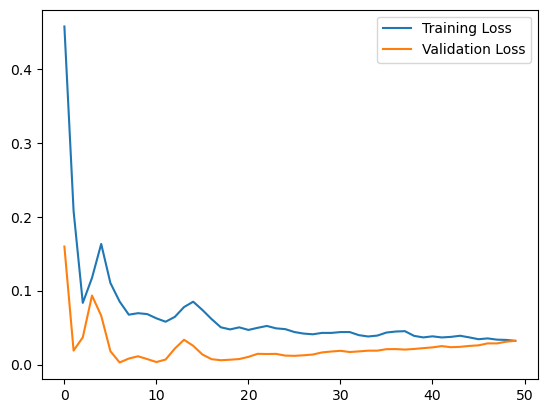

1/1 [==============================] - 1s 727ms/step
Root Mean Squared Error: 127.34060448086204


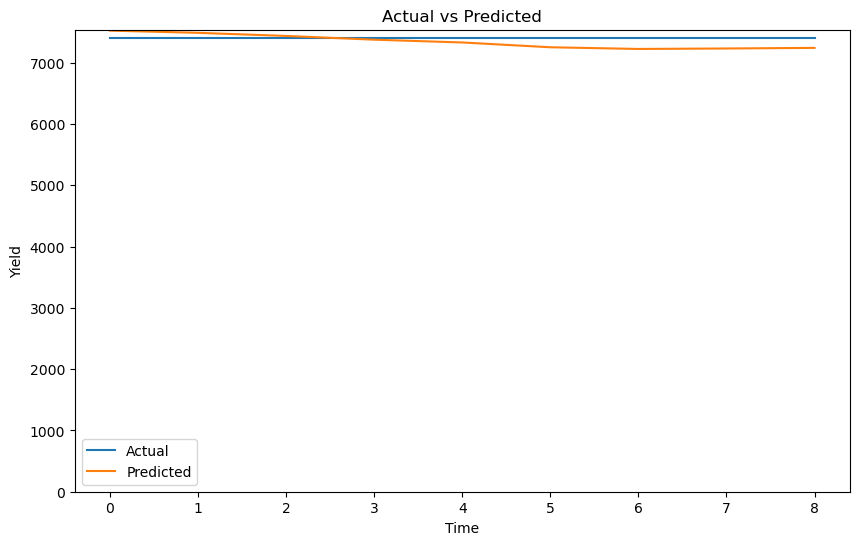

Final Actual = 7410.0, Final Predicted = 7242.334622740746
Mean Absolute Percentage Error (MAPE): 1.50%
Mean Absolute Error: 167.66537725925355
1/1 [==============================] - 0s 31ms/step
Predicted yield for next year: 7316.371176242829


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

df = pd.read_csv('WeatherData.csv', index_col='Date', parse_dates=True)

# Print the first 5 rows
print(df.head())

feature_cols = ['Htemp', 'Ltemp', 'Humidity', 'Pressure']
target_col = 'yield'

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

window_size = 7
batch_size = 50

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(train_data, train_data[:, 4],
                                                                     length=window_size, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(test_data, test_data[:, 4],
                                                                    length=window_size, batch_size=batch_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(window_size, 5), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(1, activation=None)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Evaluate the model
loss = model.evaluate(test_generator)
print('Test Loss:', loss)

# Plot the loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict the test data
test_predict = model.predict(test_generator)

# Transform the data back to its original scale
test_data_unscaled = scaler.inverse_transform(test_data)
test_predict_unscaled = scaler.inverse_transform(np.concatenate((test_data_unscaled[window_size:, :-1], test_predict), axis=1))[:, -1]
test_actual_unscaled = test_data_unscaled[window_size:, 4]

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(test_actual_unscaled, test_predict_unscaled))
print(f"Root Mean Squared Error: {rmse}")


# Plot the predicted versus actual values
plt.figure(figsize=(10, 6))
plt.plot(test_actual_unscaled, label='Actual')
plt.plot(test_predict_unscaled, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.ylim(bottom=0)
plt.legend()
plt.show()

# Display the final predicted value
final_actual = test_actual_unscaled[-1]
final_predicted = test_predict_unscaled[-1]
print(f"Final Actual = {final_actual}, Final Predicted = {final_predicted}")

# Calculate the Mean Absolute Percentage Error (MAPE)
test_actual_percentage = test_actual_unscaled / final_actual * 100
test_predict_percentage = test_predict_unscaled / final_predicted * 100
mape = np.mean(np.abs(test_actual_percentage - test_predict_percentage))
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Compute the MAE
mae = mean_absolute_error([final_actual], [final_predicted])
print(f"Mean Absolute Error: {mae}")


# Load the weather data for next year
next_year_weather = pd.read_csv('NewData.csv', index_col='Date', parse_dates=True)

# Normalize the data using the same scaler as before
next_year_data = scaler.transform(next_year_weather.values)

# Create a time series generator for the new data
next_year_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(next_year_data, np.zeros(len(next_year_data)), 
                                                                           length=window_size, batch_size=batch_size)

# Use the trained LSTM model to make predictions on the new data
next_year_predict = model.predict(next_year_generator)

# Transform the predicted values back to their original scale
next_year_predict_unscaled = scaler.inverse_transform(np.concatenate((next_year_data[window_size:, :-1], next_year_predict), axis=1))[:, -1]

# Print the predicted yield for next year
print(f"Predicted yield for next year: {next_year_predict_unscaled[-1]}")